# Kinetics V

This lecture covers multiple linear regression; estimation of multiple parameters using nonlinear regression; and the analysis of data obtained in integral tubular reactors (plug flow or packed bed reactors). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example Problem 01 (Continuation from Kinetics IV)

We next consider a data set where not much has been done systematically. Someone decided to perform a "kinetic study" of the following reaction in a CSTR.

$$A + 2B \longrightarrow 3C$$

We propose that the rate of reaction depends on concentrations of A and B in some power law model:

$$r = kC_A^\alpha C_B^\beta$$

We want to estimate $k$, $\alpha$, and $\beta$.  Our conventional wisdom is that, to determine a parameter, you need to vary the quantity influenced that parameter while holding everything else constant.  For example, if you wanted to know $\alpha$, the most straightforward experiment would be one that measures $r$ for various values of $C_A$ while holding $C_B$ constant.  This would allow you to isolate the impact of $C_A$ on reaction rate and therefore estimate $\alpha$.  

Here our experimentalist made some interesting choices in how they ran the experiment.  They varied space time (by varying feed flowrate), and they also seem to have been randomly changing the feed concentrations of both A and B with every change in residence time. We'd love to get an estimate for k, $\alpha$, and $\beta$, but it isn't quite clear how we would do that based on the data available.

The data are in an attached CSV file.  

### Importing into a dataframe with pandas

The code in the cell below will import the data as a dataframe, which has the display characteristics of a table or spreadsheet; we are doing this just to see the data that we hav eon hand: it includes residence times ($\tau$); feed concentrations of A, B, and C ($C_{Af}$ and $C_{Bf}$); and fractional conversion of A measured at at the reactor exit.

In [2]:
import pandas as pd
dataframe = pd.read_csv("CSTRDATA32.csv")
dataframe

,tau (min),Caf (mol/L),CBf (mol/L),CCf (mol/L),XA,CA (mol/L),CB (mol/L),CC (mol/L)
0,34.877,0.40,1.55,0.0,0.894,0.042,0.824,1.077
1,0.103,0.83,2.38,0.0,0.141,0.727,2.209,0.366
2,0.646,0.27,1.00,0.0,0.158,0.218,0.923,0.118
3,0.923,0.68,2.16,0.0,0.439,0.392,1.507,0.846
4,0.217,0.39,0.94,0.0,0.057,0.362,0.806,0.061
5,8.653,0.68,1.56,0.0,0.613,0.246,0.753,1.371
6,36191.127,0.06,0.13,0.0,0.881,0.007,0.025,0.170
7,0.774,0.40,1.42,0.0,0.278,0.296,1.125,0.363
8,423.825,0.10,0.34,0.0,0.820,0.018,0.188,0.254
9,8.683,0.22,0.85,0.0,0.533,0.098,0.605,0.366


### Importing data as a numpy array

The cell below uses Python's csv reader to parse the input file (CSTRdata.csv).  It stores the information in an array called "data".

In [3]:
import csv
labels = ['r (mol/L/min)']
file      = open("CSTRDATA32.csv")
csvreader = csv.reader(file)
header    = []
header    = next(csvreader)
for value in labels:
    header.append(value)
rows      = []
for row in csvreader:
    rows.append(row)
file.close()
data = np.array(rows, dtype = 'float')

In [4]:
taudata   = data[:, 0]
CAfdata   = data[:, 1]
CBfdata   = data[:, 2]
CCfdata   = data[:, 3]
XAdata    = data[:, 4]
CAdata    = data[:, 5]
CBdata    = data[:, 6]
CCdata    = data[:, 7]

In [5]:
rdata     = CCdata/3/taudata
data_all  = np.hstack([data, rdata.reshape(len(rdata), 1)])
data_all
dataframe = pd.DataFrame(data_all, columns = header)
dataframe

,tau (min),Caf (mol/L),CBf (mol/L),CCf (mol/L),XA,CA (mol/L),CB (mol/L),CC (mol/L),r (mol/L/min)
0,34.877,0.40,1.55,0.0,0.894,0.042,0.824,1.077,0.010293
1,0.103,0.83,2.38,0.0,0.141,0.727,2.209,0.366,1.184466
2,0.646,0.27,1.00,0.0,0.158,0.218,0.923,0.118,0.060888
3,0.923,0.68,2.16,0.0,0.439,0.392,1.507,0.846,0.305525
4,0.217,0.39,0.94,0.0,0.057,0.362,0.806,0.061,0.093702
5,8.653,0.68,1.56,0.0,0.613,0.246,0.753,1.371,0.052814
6,36191.127,0.06,0.13,0.0,0.881,0.007,0.025,0.170,0.000002
7,0.774,0.40,1.42,0.0,0.278,0.296,1.125,0.363,0.156331
8,423.825,0.10,0.34,0.0,0.820,0.018,0.188,0.254,0.000200
9,8.683,0.22,0.85,0.0,0.533,0.098,0.605,0.366,0.014050


### Multiple Linear Regression

We can linearize this problem.  We have a set of rates measured at a set of exit concentrations for A, B, and C.  We know that the rate of reaction should be given by a power law:

$$r = k{C_A}^\alpha {C_B}^\beta$$

This can be linearized as usual by taking logarithms of both sides to give:

$$\ln(r) = \ln(k) + \alpha \ln(C_A) + \beta \ln(C_B)$$

Putting this into matrix form, we would have:

$$XA = Y$$

Where

X is a vandermonde type matrix in which each row is:

$$X[i,:] = \begin{bmatrix} \ln(C_A)_i & \ln(C_B)_i & 1 \end{bmatrix}$$ 

Where

$$A = \begin{bmatrix} \alpha \\ \beta \\ \ln{k} \end{bmatrix}$$

And where Y is a vector of our measurements, in this case, ln(r), so each entry is given by:

$$Y[i] = \ln(r)_i$$

With those definitions, we can perform linear regression as usual.  Below, I create the X matrix manually because I don't know offhand of an automated way to generate the X matrix for multiple linear regression.  Once that is done, you solve the least squares problem as usual:

$$\hat{A} = (X^\prime X)^{-1}X^\prime Y$$

[ 0.99269111  2.02878695 -1.06409078] 

R2 = 0.999
α = 0.993 plus/minus 0.096
β = 2.029 plus/minus 0.111
ln(k) = -1.064 plus/minus 0.1459
k ~ 0.345 s^-1


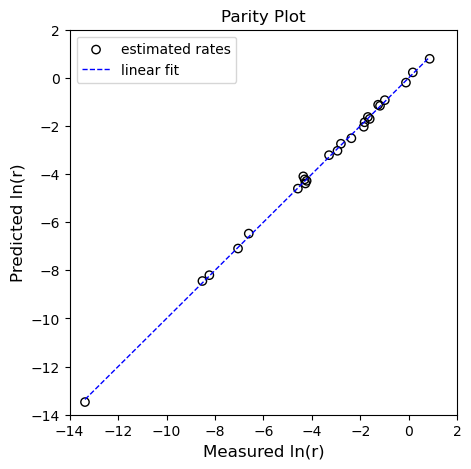

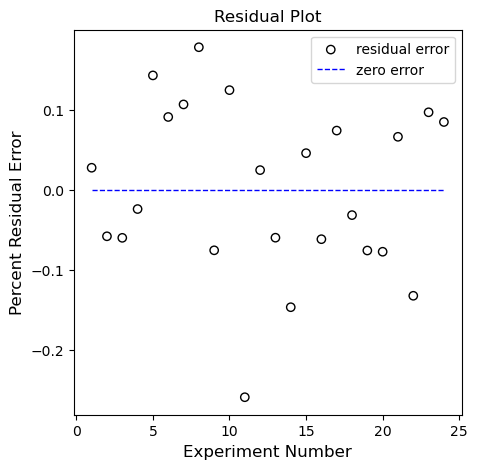

In [6]:
X      = np.ones((len(rdata),3))       #Design matrix X
X[:,0] = np.log(CAdata)
X[:,1] = np.log(CBdata)
Y      = np.log(rdata)                 #Vector of observables, Y
A      = np.linalg.solve(X.T@X, X.T@Y) #Solve for unknown coefficiens, ln(k), α, β
SSE    = (Y - X@A).T@(Y-X@A)           #Residual sum of squares
SST    = sum((Y - np.mean(Y))**2)      #Total sum of squares
Ypred  = X@A
R2     = 1 - SSE/SST                   #R2
s2     = SSE/(len(Y) - len(A))         #Approximation for variance
cov    = s2*np.linalg.inv((X.T@X))     #covariance matrix
se     = np.sqrt(abs(cov))             #standard error matrix; diagonal elements are standard error for coeffs
ci     = stats.t.ppf(0.975, len(Y) - len(A))*se #confidence intervals
Ypred  = X@A   #predicted values of Y

print(A, '\n')
print(f'R2 = {R2:3.3f}')
print(f'α = {A[0]:3.3f} plus/minus {ci[0,0]:3.3f}')
print(f'β = {A[1]:3.3f} plus/minus {ci[1,1]:3.3f}')
print(f'ln(k) = {A[2]:3.3f} plus/minus {ci[2,2]:3.4f}')
print(f'k ~ {np.exp(A[2]):3.3f} s^-1')

plt.figure(1, figsize = (5, 5))
plt.scatter(Y, Ypred, marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.plot([min(Y), max(Y)], [min(Y), max(Y)], color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('Measured ln(r)', fontsize = 12)
plt.ylabel('Predicted ln(r)', fontsize = 12)
plt.title('Parity Plot')
plt.xlim(-14.0, 2.0)
plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(np.arange(1, len(Y)+1, 1), (Y - Ypred), marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, 1, len(Y), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('Experiment Number', fontsize = 12)
plt.ylabel('Percent Residual Error', fontsize = 12)
plt.title('Residual Plot')
#plt.xlim(-14.0, 2.0)
#plt.ylim(-14.0, 2.0)
plt.legend()
plt.show()


## Example Problem 02

The following reaction is carried out in a Plug Flow Reactor operating at steady state.   

$$A \longrightarrow B$$

You measure the feed concentration of A very accurately for this system, and you find it to be 0.209 moles per liter. As in the CSTR example, we vary volumetric flowrates to span a large range of space times.  For each one, we measure the exit concentration of species A.  The data are compiled in the table below. 


|**$\tau$ (sec)** | **C$_A$ (mol/L)** |
|:---------------:|:-----------------:|
|0.133  | 2.11 $\times$ 10$^{-1}$ |
|0.267  | 1.97 $\times$ 10$^{-1}$ |
|0.667  | 1.99 $\times$ 10$^{-1}$ |
|1.333  | 1.79 $\times$ 10$^{-1}$ |
|2.667  | 1.53 $\times$ 10$^{-1}$ |
|6.667  | 1.14 $\times$ 10$^{-1}$ |
|13.33  | 8.64 $\times$ 10$^{-2}$ |
|26.67  | 6.45 $\times$ 10$^{-2}$ |
|66.67  | 4.33 $\times$ 10$^{-2}$ |
|133.3  | 3.02 $\times$ 10$^{-2}$ |

Assuming the reaction rate is described by power law kinetics,

$$r = k \, {C_A}^{\alpha}$$ 

where $\alpha$ is an integer, use the measured concentrations of A in the reactor effluent to determine the reaction order in A and the rate constant for this reaction.  You may assume that the density of the fluid is constant.

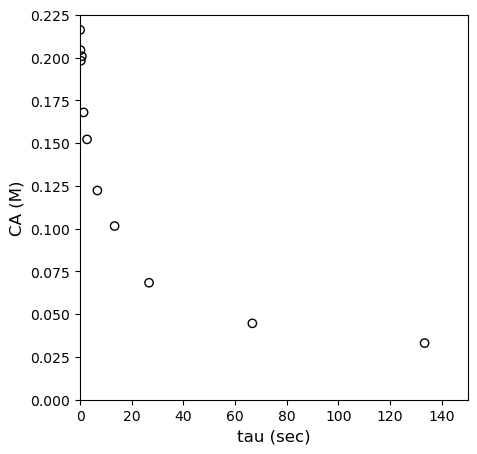

In [7]:
CAf     = 0.209 #mol/L
tau_exp = np.array([0, 0.133333333, 0.266666667, 0.666666667, 1.333333333, 2.666666667, 6.666666667, 13.33333333, 26.66666667, 66.66666667, 133.3333333])
CA_exp  = np.array([0.216138658, 0.204299214, 0.198122853, 0.200721526, 0.167904995, 0.152141971, 0.12226356, 0.101508811, 0.068370453, 0.044628989, 0.033106474])

plt.figure(1, figsize = (5, 5))
plt.scatter(tau_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('tau (sec)', fontsize = 12)
plt.ylabel('CA (M)', fontsize = 12)
plt.xlim(0, 150)
plt.ylim(0, 0.225)
plt.show()

### Solution to Example Problem 02

Here we have what we would call an "integral" PFR.  By that we mean the conversion, concentration, and reaction rate change across the length of the PFR.  So, to predict the concentration measured at the exit of the CSTR, we have to **integrate** the PFR material balance.  Once we do that, we can compare our predictions with the measurement, assess goodness of fit, and estimate important parameters like the reaction order and the rate constant.

Let's start with the material balance on the PFR as usual:

$$\frac{dF_A}{dV} = R_A$$

Here, we have a single reaction where the coefficient on A is -1, so $R_A = -r$:

$$\frac{dF_A}{dV} = -r$$

We have to address one issue, though.  The data are presented as exit concentration of A measured at various **space times**, which we define as usual:

$$\tau = \frac{V}{Q_f}$$

I am not given data at various reactor volumes.  There is a good reason for this.  Usually, we are stuck with one PFR that has a fixed volume.  It would be difficult and expensive to change the reactor volume to try to assess how the exit concentration of A changes with increasing reactor volume, so we would usually do this type of experiment by varying residence time instead.  We don't do that by changing volume--that always stays fixed--we do it by varying the feed volumetric flowrate. I know that we usually think of solving the PFR balance in terms of Volume, but for a kinetics experiment, it is more convenient to work in residence time.  For that reason, we'll re-write tha balance in terms of space time.  We do that by recognizing that, for a constant density system where $Q = Q_f$, $V = \tau Q_f$.  Making that substitution:

$$\frac{dF_A}{d(\tau Q_f)} = -r$$

The feed volumetric flowrate is a constant, so we can move it outside of the denominator and into the numerator:

$$\frac{d(F_A/Q_f)}{d\tau} = -r$$

And we see that this gives us the concentration of species A in the numerator:

$$\frac{dC_A}{d\tau} = -r$$

That actually looks a lot like the material balance for a constant volume batch reactor, just with residence time replacing real time. You actually can analyze an integral PFR exactly as you would a batch reactor.  You can either use a differential analysis or integral analysis.  As a refresher:

### Differential Analysis

Here, we you use finite differences (or any other reasonable method) to estimate the derivative of $C_A$ with respect to $\tau$ from our experimental data:

$$r \approx -\frac{\Delta C_A}{\Delta \tau}$$

and then linearize as usual:

$$\ln(r) = \ln(k) + \alpha \ln(C_A)$$

That analysis virtually identical to differential analysis of a batch reactor.  It will give you a rough estimate of the reaction order and rate constant, but it can amplify noise in the data.

### Integral Analysis

Alternatively, you can use an integral analysis just like in a batch reactor.  To this point, we've always handled an integral analysis by assuming a reaction order, e.g.:

First order

$$r = kC_A$$

Second order

$$r = k{C_A}^2$$

Third order

$$r = k{C_A}^3$$

etc.  Then we would solve the material balance by integrating. For example, for a first order process, we would solve:

$$\frac{dC_A}{d\tau} = -kC_A$$

Which would give:

$$C_A = C_{A,f}\exp{(-k \tau)}$$

Which can be linearized in a form like this one:

$$\ln \left(\frac{C_A}{C_{A,f}}\right) = - k \tau$$

If we plot our data in this form, we can assess linearity/goodness of fit, and regress parameters. We can then do the same thing for a second order reaction or a third order reaction. Again, this is identical to what we've already covered in a batch reactor, we just work in $\tau$ instead of real time. 

I want to instead use a method that we haven't seen before.  It is an integral analysis since we'll be solving the differential equation, but we'll do it a bit differently than just guessing random reaction orders.  We'll consider only two cases:

**First order kinetics**

As shown above, if the kinetics are first order, then we know that the following solution for exit concentration will hold:

$$C_A = C_{A,f}\exp{(-k \tau)}$$

And we know we can linearize this model by taking a natural logarithm of both sides.

**Unknown order kinetics**

Now we'll re-solve the material balance symbolically with an unknown reaction order, $\alpha$:

$$\frac{dC_A}{d\tau} = -k{C_A}^\alpha$$

This is a separable ODE:

$$\frac{1}{{C_A}^\alpha}dC_A = -kd\tau$$

It's actually not hard to solve this symbollically.  We know how to integrate both sides of that equation.  Applying appropriate limits:

$$\int_{C_{A,f}}^{C_A} \frac{1}{{C_A}^\alpha}dC_A = \int_0^\tau-kd\tau$$

We can solve to get:

$$C_A = \left[ C_{A,f}^{(1 - \alpha)} - (1 - \alpha)k\tau\right]^\left(\frac{1}{1 - \alpha}\right)$$

It's a bit of a cumbersome equation, but it isn't *hard* to work with.  If we think about it, this is actually a nonlinear model that describes how the concentration of species A changes as a function of residence time, $\tau$.  I can therefore use that model to generate predictions of the Concentration of A at various values of $\tau$.  If I can do that, I can quantify error and calculate a residual sum of squares:

$$SSE = \sum_i \left(C_{A_i} - \hat{C}_{A_i}\right)^2$$

We can then use an optimization algorithm to minimze the SSE with respect to the values of $\alpha$ and $k$.  This is implemented below.

Note that this model does not work for a first order reaction ($\alpha$ = 1) since the exponent on the bracketed term goes to infinity in that situation.  For that reason, we'll first test our data against a first order model to see if it is first order.

We'll do this by plotting:

$\ln\left(\frac{C_A}{C_{A,f}}\right)$ vs. $\tau$. If that is linear, then kinetics are first order, and we'll work up the problem that way.  If it is nonlinear, we'll go back to our model written in terms of $\alpha$.

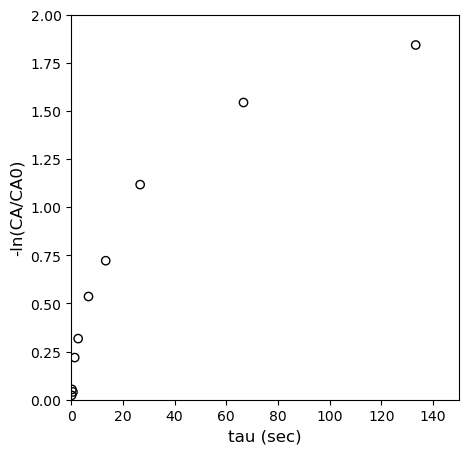

In [8]:
Y = -1*np.log(CA_exp/CAf).reshape(len(CA_exp))
X = tau_exp.reshape(len(tau_exp),1)

plt.figure(1, figsize = (5, 5))
plt.scatter(X, Y, marker = 'o', color = 'none', edgecolor = 'black')
plt.xlabel('tau (sec)', fontsize = 12)
plt.ylabel('-ln(CA/CA0)', fontsize = 12)
plt.xlim(0, 150)
plt.ylim(0, 2)
plt.show()

That isn't even close, but if you want to see how nonlinear this data is, you can always fit a line to it using a method of your choice.

m    = 1.70e-02 +/- 5.34e-03
SSE  = 1.33
SST  = 4.29
MSE  = 0.12
RMSE = 0.35
R2   = 0.69
k    = 1.70e-02 +/- 5.34e-03


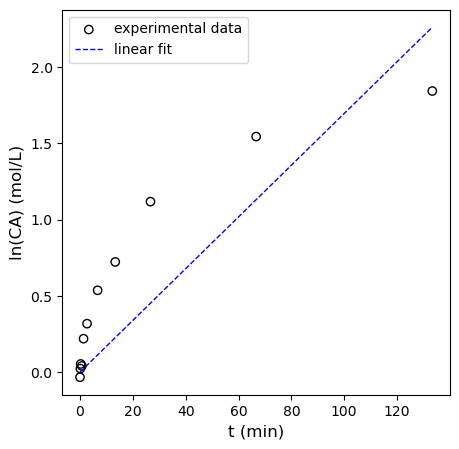

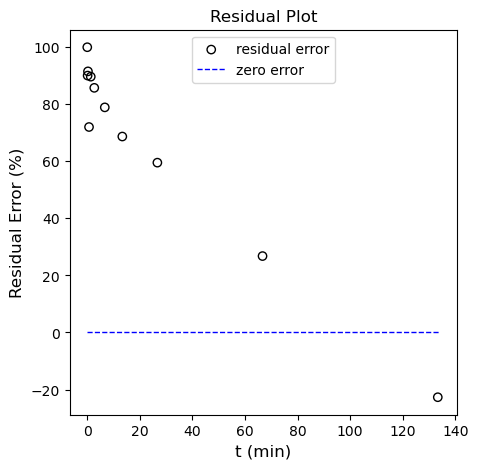

In [9]:
Y = -1*np.log(CA_exp/CAf).reshape(len(CA_exp))
X = tau_exp.reshape(len(tau_exp),1)

ydata = Y
xdata = X

A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.exp(b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

So, yeah.  That is the "best fit" straight line with a zero y-intercept that goes through our data.  It definitely isn't a first order reaction, so let's return to the generic model:

$$C_A = \left[ C_{A,f}^{(1 - \alpha)} - (1 - \alpha)k\tau\right]^\left(\frac{1}{1 - \alpha}\right)$$

We'll write an objective function to calculate that model's prediction for $C_A$:

In [10]:
def CA_mod(k, alpha, tau):
    CAf = 0.209 #mol/L
    CA  = (CAf**(1 - alpha) - (1 - alpha)*k*tau)**(1/(1 - alpha))
    return CA

With that, I can solve for model predictions given any value of k, alpha, and tau.  Here, I'll just assume some values of k and alpha, and we'll plot the resulting model prediction for all of our experimental residence times and compare it with our measurements:

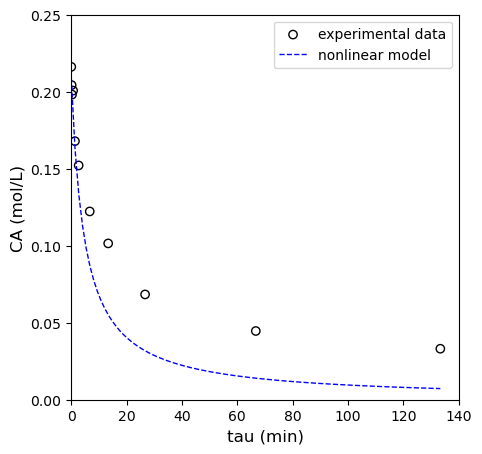

In [11]:
kguess = 1
aguess = 2
tauset = np.linspace(0, max(tau_exp), 100)
plt.figure(1, figsize = (5, 5))
plt.scatter(tau_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(tauset, CA_mod(kguess, aguess, tauset), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'nonlinear model')
plt.xlabel('tau (min)', fontsize = 12)
plt.ylabel('CA (mol/L)', fontsize = 12)
plt.xlim(0, 140.0)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

OK, that's not a bad fit, but it probably also isn't the best fit.  We can do better if we write an objective function and use an optimization algorithm to solve for the best fit values of k and alpha.  We'll do that below.

In [12]:
def OBJ(par):
    k, α = par
    CA_pred = CA_mod(k, α, tau_exp)
    SSE     = np.sum((CA_exp - CA_pred)**2)
    return SSE

par0   = [1, 3]
answer = opt.minimize(OBJ, par0)
print(answer, '\n')
k_opt = answer.x[0]
a_opt = answer.x[1]
CA_pred = CA_mod(k_opt, a_opt, tau_exp)

print(f'k = {k_opt:3.3f}, α = {a_opt:3.3f}')

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00031337375509744424
        x: [ 3.901e+00  3.070e+00]
      nit: 26
      jac: [-4.250e-07  2.948e-06]
 hess_inv: [[ 4.025e+04  5.056e+03]
            [ 5.056e+03  6.519e+02]]
     nfev: 90
     njev: 30 

k = 3.901, α = 3.070


Now that we have optimum parameters, we'll overlay the optimum fit with our experimental data and see how it does.

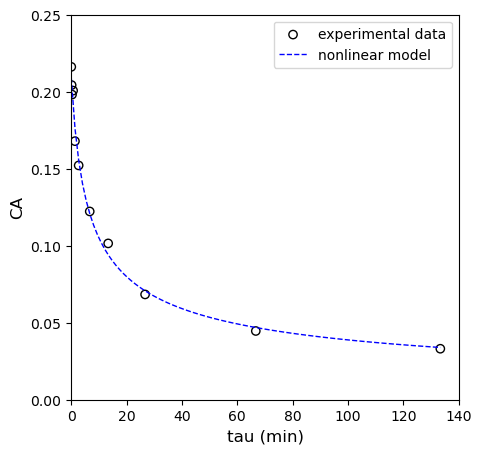

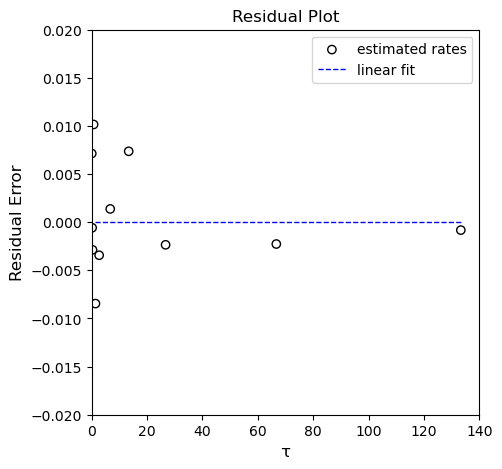

In [13]:
plt.figure(1, figsize = (5, 5))
plt.scatter(tau_exp, CA_exp, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(tauset, CA_mod(k_opt, a_opt, tauset), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'nonlinear model')
plt.xlabel('tau (min)', fontsize = 12)
plt.ylabel('CA', fontsize = 12)
plt.xlim(0, 140.0)
plt.ylim(0, 0.25)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(tau_exp, (CA_exp - CA_pred), marker = 'o', color = 'none', edgecolor = 'black', label = 'estimated rates')
plt.hlines(0, 1, ceil(max(tau_exp)), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('τ', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.title('Residual Plot')
plt.xlim(0, 140.0)
plt.ylim(-0.02, 0.02)
plt.legend()
plt.show()


### Linearizing the third order fit

Looks like a great fit!!!  We are thus reasonably confident that our optimized parameter values along with the nonlinear model do a good job of capturing the data.  Based on that, I'd suggest that the reaction is 3rd order.  In general, we have to recognize that the precision of each estimated parameter decreases when we increase the number of parameters estimated. The most precise estimate of the rate constant would be giving by then solving the material balance for third order kinetics:

$$\frac{dC_A}{d\tau} = -k{C_A}^3$$

This would give:

$$\frac{1}{2{C_A}^2} = \frac{1}{2{C_{A,f}}^2} + k \tau$$

We could use that linearization to regress the rate constant

m    = 3.38e+00 +/- 1.04e-01
SSE  = 334.23
SST  = 199493.82
MSE  = 30.38
RMSE = 5.51
R2   = 1.00
k    = 3.38e+00 +/- 1.04e-01


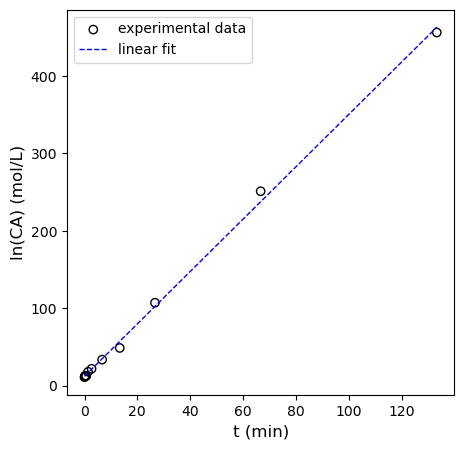

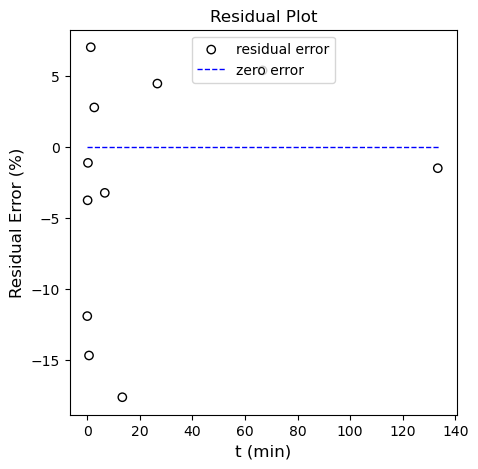

In [14]:
ydata  = 1/2/CA_exp**2
xdata  = tau_exp
Y      = ydata
X      = np.vander(xdata, 2)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.exp(b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()

### Forcing the intercept to improve precision


I prefer the following since it avoids estimation of a y-intercept and improves our precision on the slope.

$$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A,f}}^2} =  + k \tau$$

So in this linearization, we'd plot:

$\frac{1}{2{C_A}^2} - \frac{1}{2{C_{A,f}}^2}$ vs. $\tau$.  The slope of that line is your rate constant.

m    = 3.39e+00 +/- 8.49e-02
SSE  = 336.57
SST  = 199493.82
MSE  = 30.60
RMSE = 5.53
R2   = 1.00
k    = 3.39e+00 +/- 8.49e-02


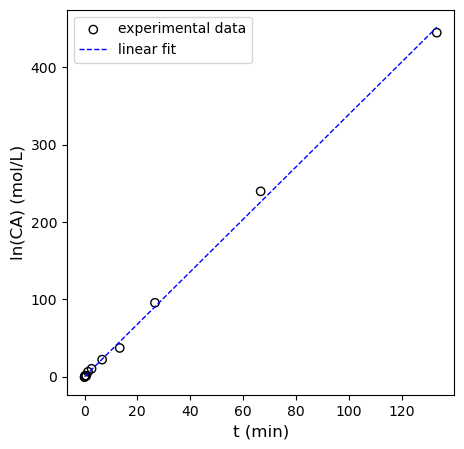

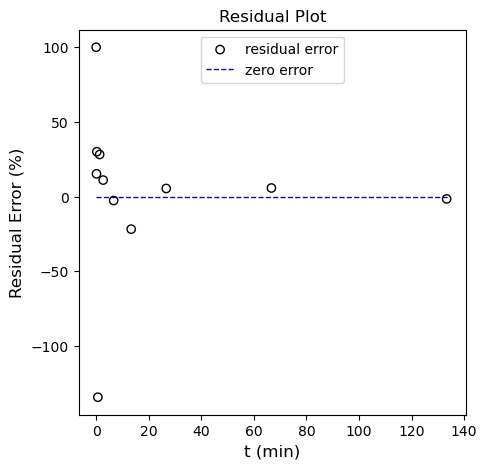

In [15]:
ydata = (1/2/CA_exp**2 - 1/2/CAf**2)
xdata = tau_exp

Y     = ydata
X     = tau_exp.reshape(len(tau_exp),1)
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                  #slope of best fit line
# b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
# SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
# CIb   = SEb*tval              #95% confidence interval on y-intercept
k     = m
# CA0   = np.exp(b)
labels = ['m', 'SSE', 'SST','MSE','RMSE', 'R2', 'k']
values = [m  ,  SSE ,  SST , MSE , RMSE ,  R2, k]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'k':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    else:
        print(f'{label:4s} = {value:0.2f}')
        
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black', label = 'experimental data')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('ln(CA) (mol/L)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('t (min)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.legend(loc = 'upper center')
plt.show()